# Covid-19 Switzerland - Logistic model

In [2]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
# Import
import io
from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from scipy.optimize import curve_fit, fsolve

<IPython.core.display.Javascript object>

## Data

In [4]:
# Loading the data from https://github.com/daenuprobst/covid19-cases-switzerland
url = "https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/covid_19_cases_switzerland_standard_format.csv"
s = requests.get(url).content
df_cases = pd.read_csv(io.StringIO(s.decode("utf-8")), parse_dates=True)
# Transform date
df_cases.index = pd.to_datetime(df_cases["date"], format="%Y-%m-%d %H:%M:%S")
del df_cases["date"]

<IPython.core.display.Javascript object>

In [5]:
df_cases.head()

,country,abbreviation_canton,name_canton,lat,long,hospitalized_with_symptoms,intensive_care,total_hospitalized,home_confinment,total_currently_positive_cases,new_positive_cases,recovered,deaths,total_positive_cases,tests_performed
date,,,,,,,,,,,,,,,
2020-03-06,Switzerland,AG,Aargau,47.449406,8.327495,NaN,NaN,NaN,NaN,10.0,0.0,NaN,NaN,NaN,NaN
2020-03-06,Switzerland,AI,Appenzell Innerrhoden,47.328414,9.409647,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2020-03-06,Switzerland,AR,Appenzell Ausserrhoden,47.382710,9.271860,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN
2020-03-06,Switzerland,BE,Bern,46.916667,7.466667,NaN,NaN,NaN,NaN,20.0,0.0,NaN,0.0,NaN,NaN
2020-03-06,Switzerland,BL,Baselland,47.482779,7.742975,NaN,NaN,NaN,NaN,9.0,0.0,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

## Total positive cases

In [6]:
# Interpolating missing values
cantons = list(df_cases.abbreviation_canton.unique())
canton_dfs = []
for canton in cantons:
    df_cases_canton = df_cases.loc[df_cases["abbreviation_canton"] == canton]
    df_cases_canton = df_cases_canton[["total_currently_positive_cases"]]
    df_cases_canton["total_currently_positive_cases"] = df_cases_canton[
        "total_currently_positive_cases"
    ].interpolate()
    canton_dfs.append(df_cases_canton)
# Groub by date
df_total_cases = pd.concat(canton_dfs)
df_total_cases = df_total_cases.groupby(["date"]).sum()
df_total_cases.head()

,total_currently_positive_cases
date,
2020-03-06,208.0
2020-03-07,263.0
2020-03-08,328.0
2020-03-09,376.0
2020-03-10,505.0


<IPython.core.display.Javascript object>

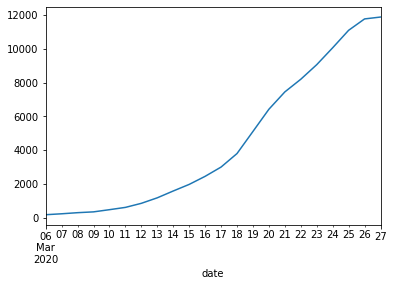

<IPython.core.display.Javascript object>

In [8]:
# Plot
df_total_cases["total_currently_positive_cases"].plot()

## Logistic model 

In [9]:
# Transform date to day of year for fitting
df_total_cases.index = df_total_cases.index.dayofyear

<IPython.core.display.Javascript object>

In [10]:
def logistic_model(x, a, b, c):
    return c / (1 + np.exp(-(x - b) / a))

<IPython.core.display.Javascript object>

In [11]:
x = list(df_total_cases.index)
y = list(df_total_cases.total_currently_positive_cases)
fit = curve_fit(logistic_model, x, y, p0=[2, 100, 20000])
errors = [np.sqrt(fit[1][i][i]) for i in [0, 1, 2]]
sol = int(
    fsolve(
        lambda x: logistic_model(x, fit[0][0], fit[0][1], fit[0][2]) - int(fit[0][2]),
        fit[0][1],
    )
)

<IPython.core.display.Javascript object>

In [10]:
# Estimated end date of the Infection
print(date.fromordinal(date(2020, 1, 1).toordinal() + sol - 1))

2020-04-25


<IPython.core.display.Javascript object>

### Plot

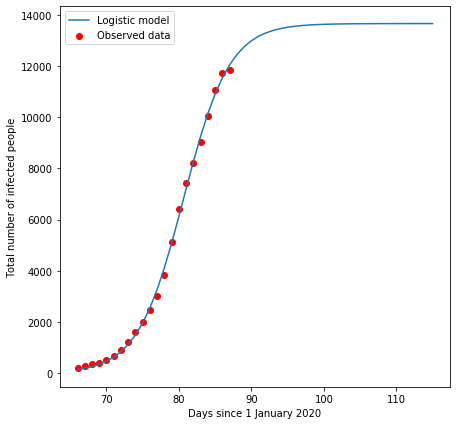

<IPython.core.display.Javascript object>

In [12]:
pred_x = list(range(max(x), sol))
plt.rcParams["figure.figsize"] = [7, 7]
# Real data
plt.scatter(x, y, label="Observed data", color="red")
# Predicted logistic curve
plt.plot(
    x + pred_x,
    [logistic_model(i, fit[0][0], fit[0][1], fit[0][2]) for i in x + pred_x],
    label="Logistic model",
)
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.savefig("model.png", dpi=600, bbox_inches="tight")
plt.show()